In [4]:
from amftrack.pipeline.development.high_mag_videos.kymo_class import *
import os
import pandas as pd
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2
from glob import glob
from tqdm import tqdm
%matplotlib widget
%load_ext autoreload
%autoreload 2
from amftrack.pipeline.functions.image_processing.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    clean_degree_4,
)
import scipy


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Welcome to the kymograph analysis pipeline module!

Use this notebook to load kymographs and extract transport flows from them. The first step is to supply some file parameters to make sure that the measurements are connected to real metrics and that the segmentation method is correct.

Important to note: 
Seg-Tresh is the limit of what percentage of the segmented image should be hypha. 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:05<00:00,  7.27s/it]


,y_mean_forw,y_mean_back,y_std_forw,y_std_back
0,23.181013,-2.066466,8.179081,5.829214
1,24.206680,-1.543975,6.611182,3.739398
2,23.131044,-3.744051,7.503837,5.961517
3,23.649469,-4.977277,6.569041,7.060769
4,23.688875,-4.109348,6.687150,6.536841
...,...,...,...,...
2123,5.393144,-3.653419,0.796012,3.880235
2124,5.319010,-4.851721,0.653177,5.666364
2125,5.320371,-3.452358,0.696140,2.546376
2126,5.316292,-0.397284,0.650658,0.259856


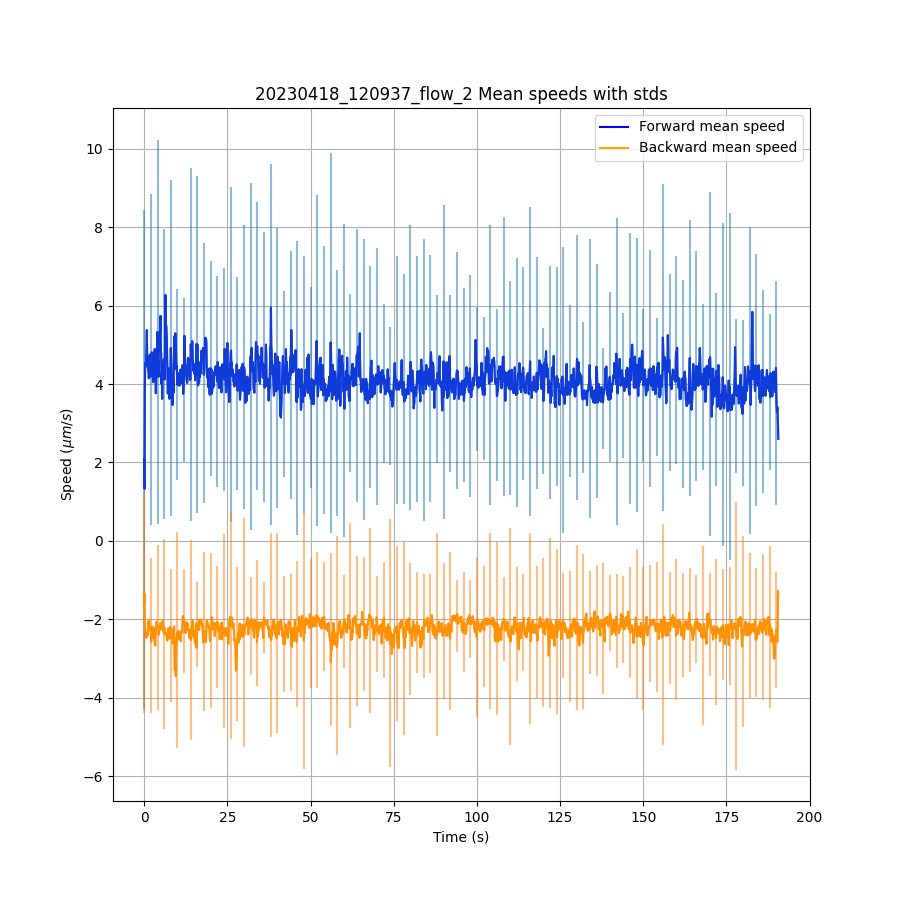

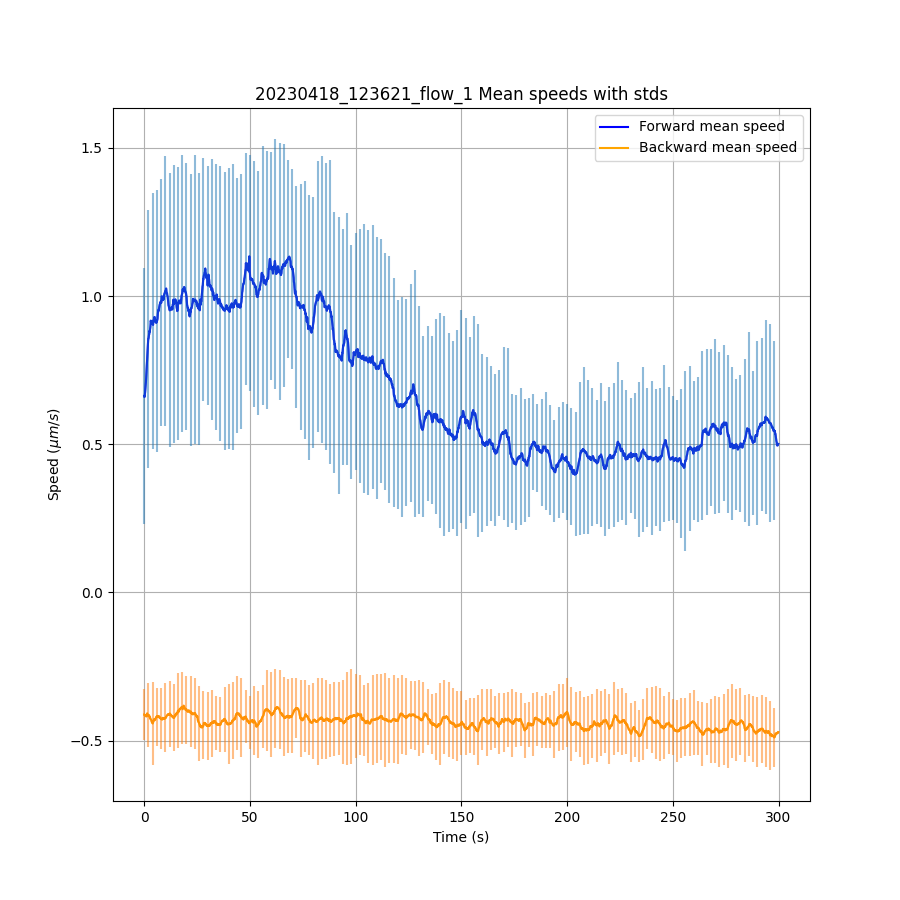

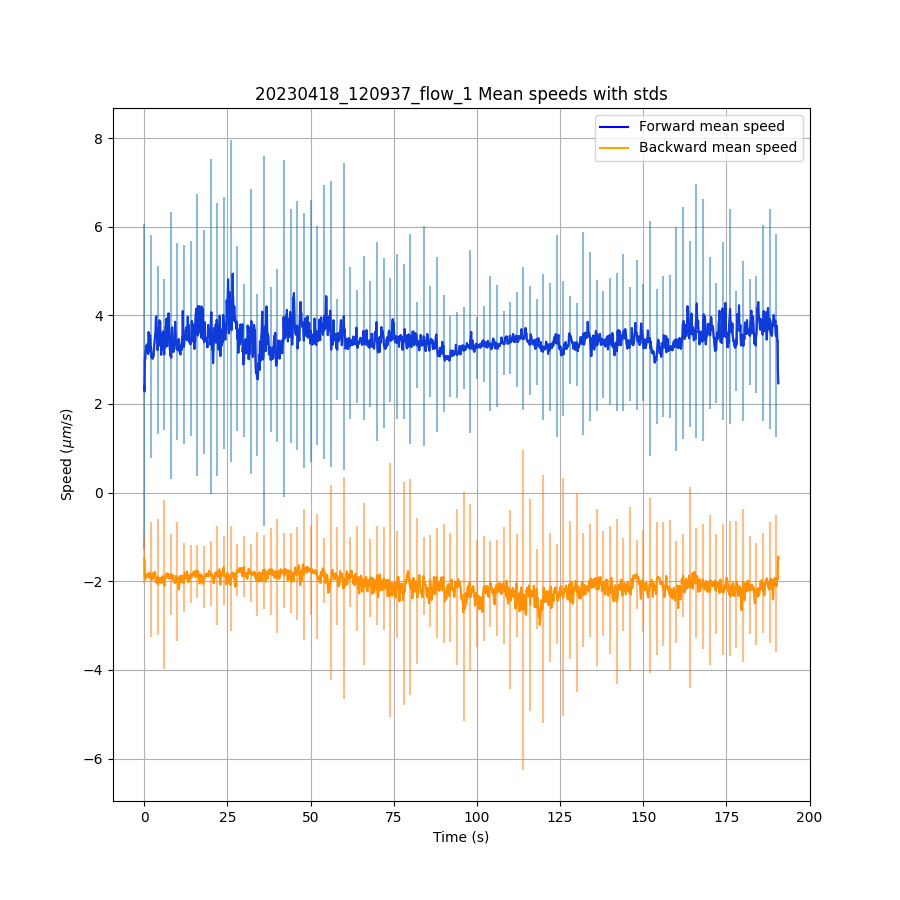

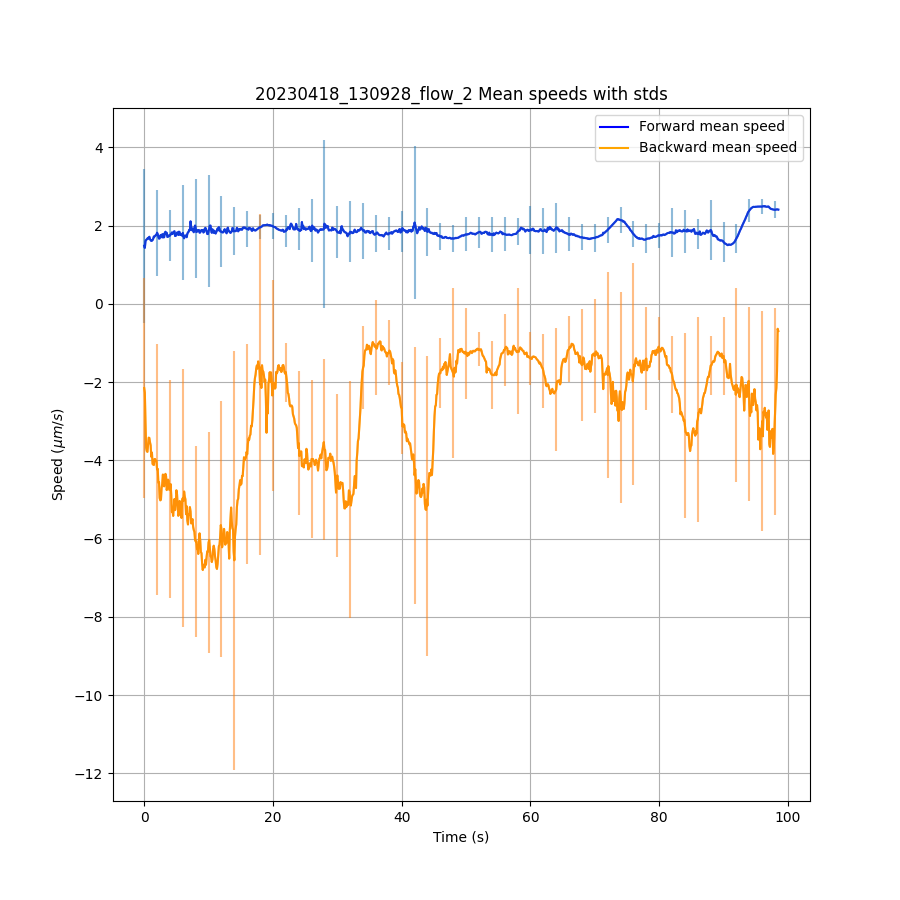

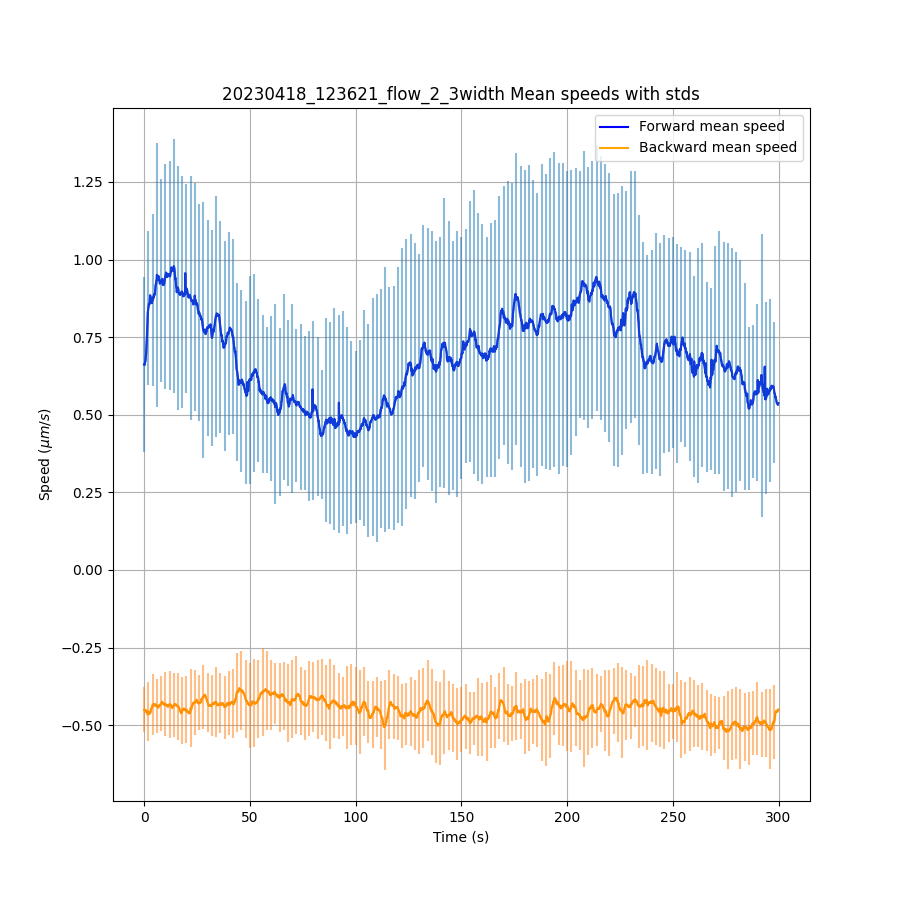

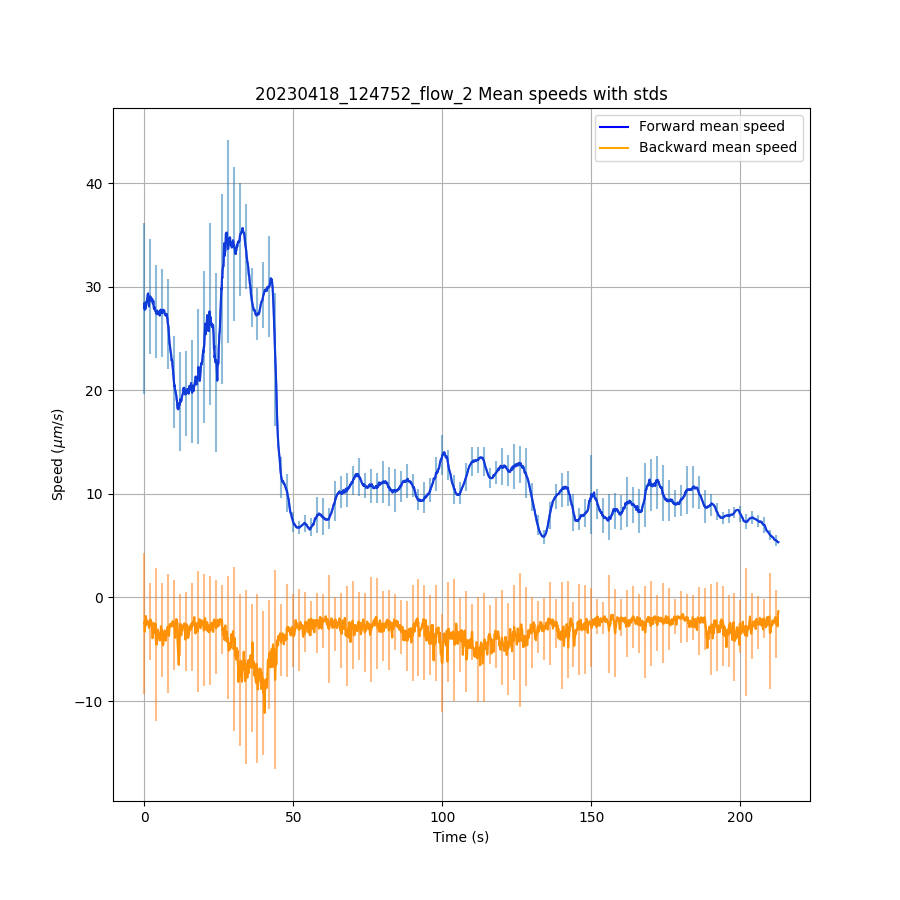

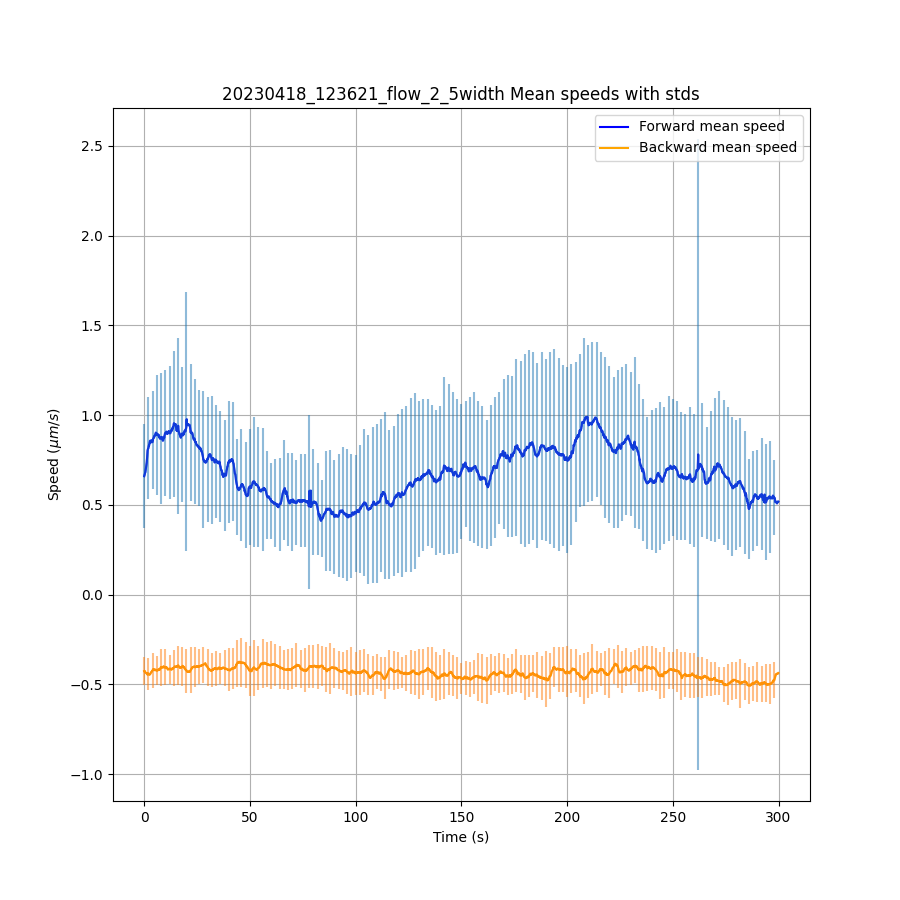

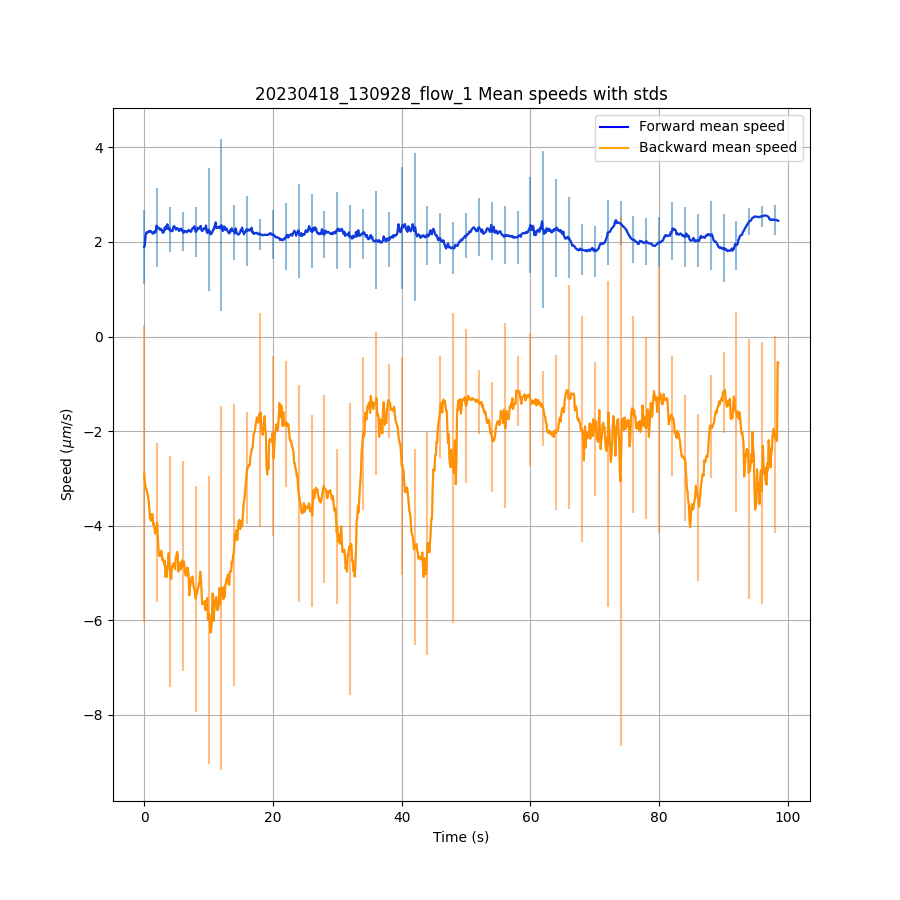

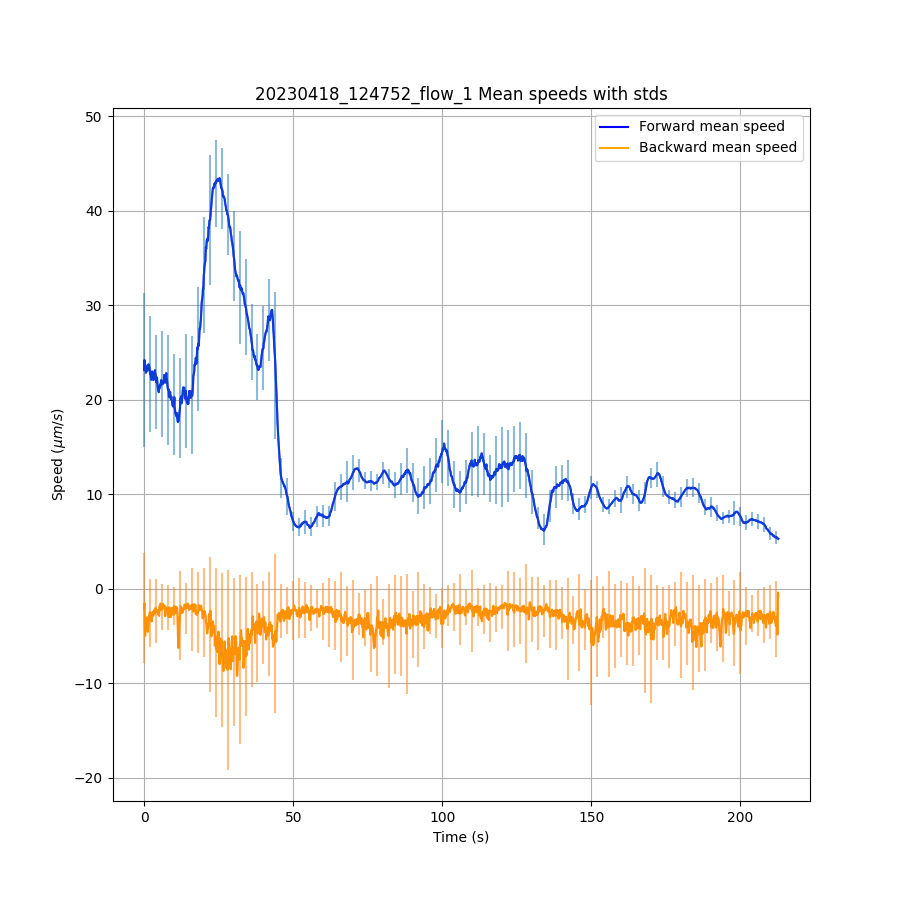

In [8]:
### Please supply a folder with kymographs. You can filter it based on the title. 
### Doing that makes it easier to set image parameters for each kymo group.
### Spatial resolution should be in micrometers

img_address = '/gpfs/home6/svstaalduine/Ready-made_kymos/*_*_flow_*.tif'
out_address = '/gpfs/home6/svstaalduine/Ready-made_kymos/'
space_resolution = 0.345
fps = 10
display_kymos=False

address_list = glob(img_address)
kymo_stack  = [imageio.imread(address) for address in address_list]
kymo_edge_list = [Kymo_edge_analysis(kymo=kymo) for kymo in kymo_stack]

for i, kymo_anal in enumerate(tqdm(kymo_edge_list)):
    title = address_list[i].split('/')[-1].split('.')[-2]
    
    imshow_extent = [0, space_resolution * kymo_anal.kymo.shape[1],
                1/fps * kymo_anal.kymo.shape[0], 0]
    kymo_anal.space_pixel_size = space_resolution
    kymo_anal.time_pixel_size = 1/fps    
    forw_thresh, back_thresh = kymo_anal.fourier_kymo(1, test_plots=False)
    speeds, times = kymo_anal.test_GST(15, w_start=3, C_thresh=0.92, C_thresh_falloff = 0.01, blur_size = 3, preblur=True, speed_thresh=50, plots=False)
    x_array = np.array(times[0])
    y_mean_back = np.nanmean(speeds[0][0], axis=1)
    y_std_back = np.nanstd(speeds[0][0], axis=1)
    y_mean_forw = np.nanmean(speeds[0][1], axis=1)
    y_std_forw = np.nanstd(speeds[0][1], axis=1)
    
    fig, ax = plt.subplots(figsize=(9, 9))
    
#     ax[0][0].imshow(forw_thresh[0], extent=imshow_extent, aspect='auto')
#     ax[0][0].set_xlabel("Space ($\mu m$)")
#     ax[0][0].set_ylabel("Time (s)")
#     ax[0][0].set_title("Forward kymo")
    
#     ax[0][1].imshow(back_thresh[0], extent=imshow_extent, aspect='auto')
#     ax[0][1].set_xlabel("Space ($\mu m$)")
#     ax[0][1].set_ylabel("Time (s)")    
#     ax[0][1].set_title("Backward kymo")

#     ax[1][0].imshow(kymo_anal.kymo, extent=imshow_extent, aspect='auto')
#     ax[1][0].set_xlabel("Space ($\mu m$)")
#     ax[1][0].set_ylabel("Time (s)")
#     ax[1][0].set_title("Original kymo")

    ax.errorbar(x_array, y_mean_forw, y_std_forw, alpha=0.5, errorevery=20)
    ax.errorbar(x_array, y_mean_back, y_std_back, alpha=0.5, errorevery=20)
    ax.plot(x_array, y_mean_forw, c='blue', label='Forward mean speed')
    ax.plot(x_array, y_mean_back, c='orange', label='Backward mean speed')
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Speed ($\mu m / s$)")
    ax.legend()
    ax.grid(True)
    ax.set_title(f"{title} Mean speeds with stds")
    plt.savefig(out_address + title)
    
    csv_dataframe = pd.DataFrame(
        {
            'y_mean_forw': y_mean_forw,
            'y_mean_back': y_mean_back,
            'y_std_forw' : y_std_forw,
            'y_std_back' : y_std_back,
        }
    )
    csv_dataframe.to_csv(out_address + title + '.csv')

    
if display_kymos:
    for kymo in kymo_stack:
        imshow_extent = [0, space_resolution * kymo.shape[1],
                1/fps * kymo.shape[0], 0]
        fig, ax = plt.subplots(figsize=(8,8))
        ax.imshow(kymo, extent=imshow_extent, aspect='auto')
        ax.set_xlabel("Space ($\mu m$)")
        ax.set_ylabel("Time (s)")
        
csv_dataframe
        


If the segmentation is satisfactory, you can proceed with plotting the edges that will be analyzed. 


 To work with individual edges, here is a list of their indices:
edge 0, (32, 3)
edge 1, (32, 2)
edge 2, (35, 32)


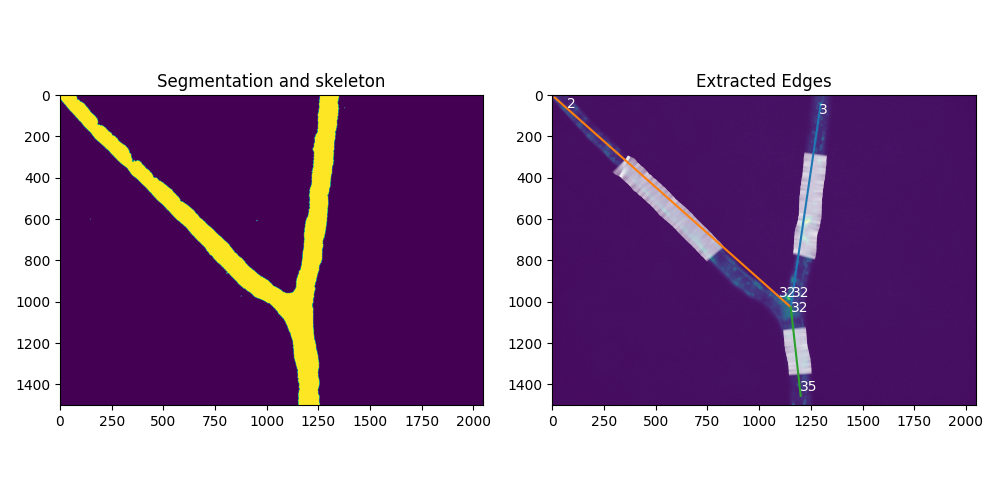

Saved the extracted edges


In [5]:
### The print statement will give you the edge indices such that you can select which edges to analyze.
print('\n To work with individual edges, here is a list of their indices:')
for i, edge in enumerate(edge_list):
    print('edge {}, {}'.format(i, edge.edge_name))
    
### Target length here determines the *width* of the analysis box. 
### Too shallow, and you won't capture the entire hypha, too big and the analysis is plagued with background.
target_length = int(1.9*test_video.magnification)

test_video.plot_extraction_img(target_length=target_length, save_img=True)
edges_total = test_video.edge_objects

## Below function will make an mp4 from the tiff files, can take a while, if you prefer to skip, that's fine.

In [ ]:
test_video.makeVideo()

## This is where you select the edges that you want to analyze.
Bin number creates a range of how the edges will be partitioned along their length.

In [6]:
edge_seq = [0,1,2]
bin_nrs = np.arange(1,9)

In [ ]:
edge_objs  = [edges_total[i] for i in edge_seq]
img_seq    = np.arange(len(edge_objs[0].video_analysis.selection_file))

### Exponential fit is performed to adjust for photobleaching
exp_fit    = test_video.fit_backgr(img_seq, plots=True)

### A video and single frame will be made of each edge to get a closer look
edge_pic   = edge.view_edge(img_frame=40 ,save_im=True, target_length = target_length)
edge_video = edge.view_edge(img_frame = img_seq, save_im=True, quality = 6, target_length=target_length)

### Analysis consists of extracting a kymograph, doing fourier filtering, then extracting speeds, then transport.
### plots in each function turn on plt plots.
for bin_nr in bin_nrs:    
    for edge in edge_objs:
        edge.extract_multi_kymo(bin_nr, target_length=target_length, plots=False, subtr_backg=False, kymo_adj=True)
        kymos_lefts, kymos_rights = edge.fourier_kymo(bin_nr, plots=False, save_im=True, save_array=True)    
        huh = edge.test_GST(20, w_start=3, C_thresh=0.95, C_thresh_falloff = 0.0, blur_size = 7, preblur=True, speed_thresh=10, plots=False)    
        huh = edge.extract_transport(noise_thresh=0.15, plots=False, save_im=True, save_flux_array=True, photobleach_adjust=False)    
    

Using linear fit
Saved an image of the edge


In [ ]:
# bins = 3
# bins_space = np.linspace(0, len(kymo[0][0]), bins+1, dtype=int)
# fig, ax = plt.subplots(1, bins)
# fig2, ax2 = plt.subplots(1, bins)
# kymo_means = np.percentile(kymo[1], .4, axis=0)
# kymo_normal = kymo[1] / kymo_means
# kymo_min, kymo_max = (np.min(kymo_normal), np.max(kymo_normal))
# for i in range(bins):
#     ax[i].plot(kymo_means[bins_space[i]:bins_space[i+1]])
#     ax2[i].imshow(kymo_normal.transpose()[bins_space[i]:bins_space[i+1]].transpose(), vmin=kymo_min, vmax = kymo_max)
# plt.show()

In [ ]:

# fig, ax = plt.subplots(1, bins)
# for i in range(1, 30):
#     for j in range(bins):
#         corr = signal.correlate(kymo[1][0], kymo[1][bins_space[j]:bins_space[j+1]][i])
#         corr /= np.max(corr)
#         lags = signal.correlation_lags(len(kymo[0][0]), len(kymo[0][bins_space[j]:bins_space[j+1]][i]))
#         ax[j].plot(lags, corr)
# plt.show()

In [ ]:
# fig, ax = plt.subplots(len(edge_objs), bin_nr, figsize=(6, 12), sharey='row')
# count = 0

# bin_space = np.linspace(0,1, bin_nr+1)

# for i in range(len(edge_objs)):
#     for j in range(bin_nr):
#         if len(edge_objs) > 1:
#             if bin_nr > 1:
#                 ax[i][j].imshow(kymo[i][j])
#                 ax[i][j].set_title(f"Kymo [{bin_space[j]}-{bin_space[j+1]}] of edge {edge_objs[i].edge_name}")
#                 ax[i][j].set_xlabel("space ($x$)")
#                 ax[i][j].set_ylabel("time ($t$)")
#             elif bin_nr == 1:
#                 ax[i].imshow(kymo[i][0])
#                 ax[i].set_title(f"Kymo of edge {edge_objs[i].edge_name}")
#                 ax[i].set_xlabel("space ($x$)")
#                 ax[i].set_ylabel("time ($t$)")
                
#         else:
#             if bin_nr == 1:
#                 ax = [ax]
#             ax[j].imshow(kymo[i][j])
#             ax[j].set_title(f"Kymo [{bin_space[j]}-{bin_space[j+1]}]")
#             ax[j].set_xlabel("space ($x$)")
#             ax[j].set_ylabel("time ($t$)")

# fig.tight_layout()
# # plt.show()

In [90]:

# fig, ax = plt.subplots(1, bins)
# for i in range(1, 30):
#     for j in range(bins):
#         corr = signal.correlate(kymo[1][0], kymo[1][bins_space[j]:bins_space[j+1]][i])
#         corr /= np.max(corr)
#         lags = signal.correlation_lags(len(kymo[0][0]), len(kymo[0][bins_space[j]:bins_space[j+1]][i]))
#         ax[j].plot(lags, corr)
# plt.show()

In [91]:
# fig, ax = plt.subplots(len(edge_objs), bin_nr, figsize=(6, 12), sharey='row')
# count = 0

# bin_space = np.linspace(0,1, bin_nr+1)

# for i in range(len(edge_objs)):
#     for j in range(bin_nr):
#         if len(edge_objs) > 1:
#             if bin_nr > 1:
#                 ax[i][j].imshow(kymo[i][j])
#                 ax[i][j].set_title(f"Kymo [{bin_space[j]}-{bin_space[j+1]}] of edge {edge_objs[i].edge_name}")
#                 ax[i][j].set_xlabel("space ($x$)")
#                 ax[i][j].set_ylabel("time ($t$)")
#             elif bin_nr == 1:
#                 ax[i].imshow(kymo[i][0])
#                 ax[i].set_title(f"Kymo of edge {edge_objs[i].edge_name}")
#                 ax[i].set_xlabel("space ($x$)")
#                 ax[i].set_ylabel("time ($t$)")
                
#         else:
#             if bin_nr == 1:
#                 ax = [ax]
#             ax[j].imshow(kymo[i][j])
#             ax[j].set_title(f"Kymo [{bin_space[j]}-{bin_space[j+1]}]")
#             ax[j].set_xlabel("space ($x$)")
#             ax[j].set_ylabel("time ($t$)")

# fig.tight_layout()
# # plt.show()